# Scraper
-----
- Extracts data from weather balloon readings
- Transforms data into standard format
- Displays data on easily understandable graphs

In [188]:
import requests
import pandas as pd
from datetime import date, datetime, timedelta
from bs4 import BeautifulSoup
import numpy as np
from math import floor
from pathlib import Path  
from alive_progress import alive_bar
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
from windrose import WindroseAxes

### Define baseline params
- URL to be used
- Columns to be extracted
- Weather stations to examine
- Current date/time

In [2]:
base_url = "http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST"

cols = ["Date", 
        "Station", 
        "Pressure", 
        "Height", 
        "Temp", 
        "DewPoint", 
        "Relative_Humidity", 
        "Mean_Mixed_Layer", 
        "Wind_Direction", 
        "Wind_Speed", 
        "Potential_Temp",
        "Equivalent_Potential_Temp",
        "Virtual_Potential_Temp"]

stations = [
    {"id": 72797, "name": "Quillayute"},
    {"id": 73033, "name": "Vernon"},
    {"id": 71109, "name": "Port Hardy"}]

now = [
    datetime.now().year, 
    datetime.now().month, 
    datetime.now().day]

## Define date range function
---
- Accept start and end date
- Return range of dates between start and end

In [3]:
# Creates date range from str format dates
# e.g. "2021-01-01"
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

## Create list of URLs to scrape
---
- Iterate throguh date ranges
- Iterate through stations
- Return list of all URLs to be scraped

In [4]:
# Create date range
# ~~~~~~~~~~~~~~~~~
dates_arr = []
start_date = date(2022, 10, 1)
#start_date = date(now[0], now[1], now[2])
end_date = date(now[0], now[1], now[2]+1)
print(f"Start Date:\t{start_date}\nEnd Date:\t{end_date}")

for single_date in daterange(start_date, end_date):
    single_date = (str(single_date).split("-")) 
    dates_arr.append([ int(x) for x in single_date ])
       
# Create list of URLs for each station
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
urls = []
dates_idx = []
station_idx = []
for d in dates_arr:
    for station in stations:
        url = base_url
        url += "&YEAR={}".format(d[0])
        url += "&MONTH={}".format(d[1])
        #url += "&FROM=" + str(now[1]) + str(now[2])
        #url += "&TO=" + str(now[1]) + str(now[2])
        url += "&FROM={:0>2d}00".format(d[2])
        url += "&TO={:0>2d}23".format(d[2])
        url += "&STNM={}".format(station["id"])
        url += "&REPLOT=1"
        urls.append(url)
        
        
        dates_idx.append("%02d-%02d-%02d" % (d[0], d[1], d[2]))
        station_idx.append(station["name"])

print(urls[0])
for url in urls:
    print(url)

Start Date:	2022-10-01
End Date:	2023-01-04
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=10&FROM=0100&TO=0123&STNM=72797&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=10&FROM=0100&TO=0123&STNM=72797&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=10&FROM=0100&TO=0123&STNM=73033&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=10&FROM=0100&TO=0123&STNM=71109&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=10&FROM=0200&TO=0223&STNM=72797&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=10&FROM=0200&TO=0223&STNM=73033&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2022&MONTH=10&FROM=0200&TO=0223&STNM=71109&REPLOT=1
http://weather.uwyo.edu/cgi-bin/sounding?region=nacon

## Extract data from list of URLs
---
- Iterate through URLs
- Extract 700 and 850 data items
- Append data to array

In [5]:
data = []
reading_idx = []
problem_urls = []

print("Extracting data from URLs: ")
with alive_bar(len(urls), force_tty=True) as bar:
    for i, url in enumerate(urls):
        search = 0
        while search >= 0:
            # scrape site data
            # ~~~~~~~~~~~~~~~~
            search += 1
            page = requests.get(url)
            soup = BeautifulSoup(page.content, "html.parser")
            results = str(soup.find('pre'))
            sevhundy = results[results.find("700"):].split()[:11]
            eightfiddy = results[results.find("850"):].split()[:11]
            
            # catch erroneous reads
            # site can hit too many requests
            # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            if 'e' not in sevhundy[0] and 'e' not in eightfiddy[0]:
                search = -1
            elif search == 10:
                print(url)
                problem_urls.append(url)
                search = -1

        # we want 700 first // 850 second
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        data.append(sevhundy)
        data[-1].insert(0, dates_idx[i])
        data[-1].insert(1, station_idx[i])
        
        data.append(eightfiddy)
        data[-1].insert(0, dates_idx[i])
        data[-1].insert(1, station_idx[i])
        
        bar()
        

print("\nComplete")

Extracting data from URLs: 
|████████████████████████████████████████| 285/285 [100%] in 10:28.1 (0.45/s)                                           

Complete


In [6]:
print("Problem URLs:")
for url in problem_urls:
    print(url)

Problem URLs:


## Clean Data
---
- Remove unwanted chars from fields
- Convert wind speed to km/h from knots

In [7]:
# Remove rogue "e" values from pressure field
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
pressures = [700, 850]
ctr = 0
for item in data:
    if(not str(item[2]).isnumeric()):
        item[2] = pressures[ctr%2]
    ctr += 1

In [8]:
df = pd.DataFrame(data, columns=cols)

# Convert DataFrame to numeric values
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for col in cols[2:]:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        print(col)
    
# Convert wind speed from Knots to KM/H
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
df['Wind_Speed'] = df['Wind_Speed'].multiply(1.852)
df.head(20)

,Date,Station,Pressure,Height,Temp,DewPoint,Relative_Humidity,Mean_Mixed_Layer,Wind_Direction,Wind_Speed,Potential_Temp,Equivalent_Potential_Temp,Virtual_Potential_Temp
0,2022-10-01,Quillayute,700,3162.0,5.0,-3.0,56.0,4.40,10.0,27.780,308.0,321.9,308.8
1,2022-10-01,Quillayute,850,1550.0,14.0,1.0,41.0,4.86,70.0,16.668,300.8,315.7,301.7
2,2022-10-01,Vernon,700,3154.0,3.0,-5.0,56.0,3.78,355.0,18.520,305.8,317.7,306.5
3,2022-10-01,Vernon,850,1542.0,14.4,5.4,55.0,6.66,355.0,20.372,301.2,321.3,302.4
4,2022-10-01,Port Hardy,700,3155.0,4.2,-4.8,52.0,3.84,270.0,24.076,307.1,319.3,307.8
5,2022-10-01,Port Hardy,850,1544.0,12.0,-4.0,32.0,3.36,175.0,5.556,298.7,309.1,299.3
6,2022-10-02,Quillayute,700,3144.0,9.0,-22.0,9.0,0.94,70.0,11.112,312.4,315.7,312.6
7,2022-10-02,Quillayute,850,1525.0,16.0,2.0,39.0,5.23,350.0,7.408,302.9,319.0,303.9
8,2022-10-02,Vernon,700,3157.0,5.0,-4.0,52.0,4.08,180.0,9.260,308.0,320.9,308.8
9,2022-10-02,Vernon,850,1542.0,17.0,4.0,42.0,6.03,165.0,3.704,303.9,322.4,305.1


In [9]:
df.tail()

,Date,Station,Pressure,Height,Temp,DewPoint,Relative_Humidity,Mean_Mixed_Layer,Wind_Direction,Wind_Speed,Potential_Temp,Equivalent_Potential_Temp,Virtual_Potential_Temp
565,2023-01-03,Quillayute,850,1349.0,-0.1,-9.1,51.0,2.27,185.0,37.040,286.0,292.8,286.4
566,2023-01-03,Vernon,700,2937.0,-4.1,-23.1,21.0,0.86,195.0,48.152,297.9,300.8,298.1
567,2023-01-03,Vernon,850,1406.0,-6.3,-7.7,90.0,2.53,135.0,18.520,279.5,286.8,280.0
568,2023-01-03,Port Hardy,700,2828.0,-9.9,-12.8,79.0,2.05,185.0,57.412,291.5,297.8,291.9
569,2023-01-03,Port Hardy,850,1318.0,-1.7,-6.7,69.0,2.74,145.0,29.632,284.4,292.4,284.8


## Export data to CSV
---
Create new file for each date the extraction is run and save to /data/ folder

In [10]:
filepath = Path('./data/raw_scrape-{}-{}-{}.csv'.format(datetime.now().year, datetime.now().month, datetime.now().day))  
filepath.parent.mkdir(parents=True, exist_ok=True) 
df.to_csv(filepath)

### Split Data by Region
---
Seperate the general DataFrame for simpler manipulation

In [11]:
df.set_index(['Date','Station','Pressure'])

Height  Temp  DewPoint  Relative_Humidity  \
Date       Station    Pressure                                              
2022-10-01 Quillayute 700       3162.0   5.0      -3.0               56.0   
                      850       1550.0  14.0       1.0               41.0   
           Vernon     700       3154.0   3.0      -5.0               56.0   
                      850       1542.0  14.4       5.4               55.0   
           Port Hardy 700       3155.0   4.2      -4.8               52.0   
...                                ...   ...       ...                ...   
2023-01-03 Quillayute 850       1349.0  -0.1      -9.1               51.0   
           Vernon     700       2937.0  -4.1     -23.1               21.0   
                      850       1406.0  -6.3      -7.7               90.0   
           Port Hardy 700       2828.0  -9.9     -12.8               79.0   
                      850       1318.0  -1.7      -6.7               69.0   

                                Mean_Mixed_Layer  Wind_Direction  Wind_Speed  \
Date       Station    Pressure                                                 
2022-10-01 Quillayute 700                   4.40            10.0      27.780   
                      850                   4.86            70.0      16.668   
           Vernon     700                   3.78           355.0      18.520   
                      850                   6.66           355.0      20.372   
           Port Hardy 700                   3.84           270.0      24.076   
...                                          ...             ...         ...   
2023-01-03 Quillayute 850                   2.27           185.0      37.040   
           Vernon     700                   0.86           195.0      48.152   
                      850                   2.53           135.0      18.520   
           Port Hardy 700                   2.05           185.0      57.412   
                      850                   2.74           145.0      29.632   

                                Potential_Temp  Equivalent_Potential_Temp  \
Date       Station    Pressure                                              
2022-10-01 Quillayute 700                308.0                      321.9   
                      850                300.8                      315.7   
           Vernon     700                305.8                      317.7   
                      850                301.2                      321.3   
           Port Hardy 700                307.1                      319.3   
...                                        ...                        ...   
2023-01-03 Quillayute 850                286.0                      292.8   
           Vernon     700                297.9                      300.8   
                      850                279.5                      286.8   
           Port Hardy 700                291.5                      297.8   
                      850                284.4                      292.4   

                                Virtual_Potential_Temp  
Date       Station    Pressure                          
2022-10-01 Quillayute 700                        308.8  
                      850                        301.7  
           Vernon     700                        306.5  
                      850                        302.4  
           Port Hardy 700                        307.8  
...                                                ...  
2023-01-03 Quillayute 850                        286.4  
           Vernon     700                        298.1  
                      850                        280.0  
           Port Hardy 700                        291.9  
                      850                        284.8  

[570 rows x 10 columns]

## Check Data

Are there any null Temp values in our dataset?

---

In [12]:
print("Null Temp values:")
df[pd.isnull(df.Temp)]

Null Temp values:


,Date,Station,Pressure,Height,Temp,DewPoint,Relative_Humidity,Mean_Mixed_Layer,Wind_Direction,Wind_Speed,Potential_Temp,Equivalent_Potential_Temp,Virtual_Potential_Temp
442,2022-12-13,Port Hardy,700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
484,2022-12-20,Port Hardy,700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
485,2022-12-20,Port Hardy,850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Plot for Quillayute
Plot for Temperature values at Quillayute

---

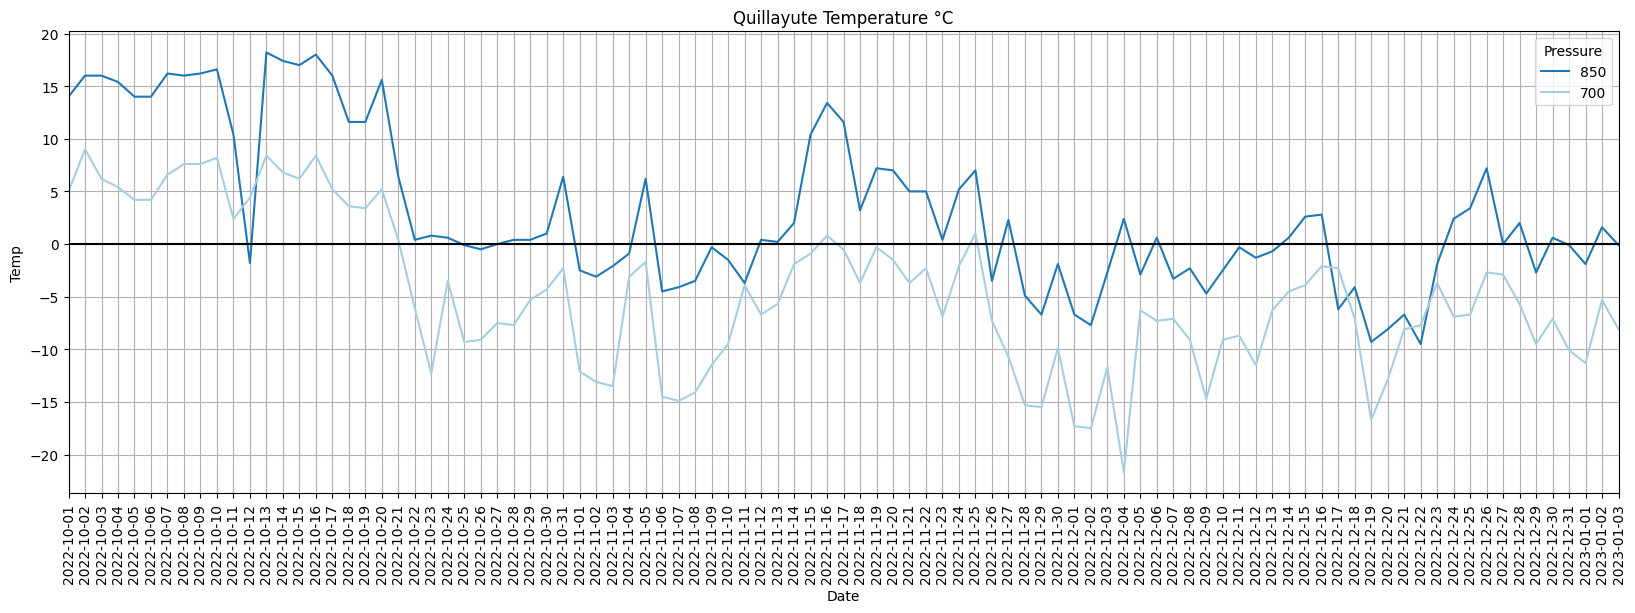

In [192]:
# Set figure details
plt.figure(figsize=(20,6))
plt.title("Quillayute Temperature °C")
plt.xticks(rotation = 'vertical')
palette = sns.color_palette("Paired", n_colors=6)
order = [1, 0, 3, 2, 5, 4]
palette = [palette[idx] for idx in order]
hue_order = [850, 700]

# Line chart showing daily temps of Quillayute weather balloon at both 700 and 850 hPa
g = sns.lineplot(x='Date', y='Temp', hue='Pressure', data=df[df['Station'] == "Quillayute"], palette=palette[0:2], hue_order=hue_order)
g.axhline(0, color='black')

# Display and Save graph
plt.xlim([0, len(df)/6 -1])
plt.grid()
plt.savefig("./figures/temp/QuillayuteTemps-{:0>4d}-{:0>2d}-{:0>2d}.png".format(datetime.now().year, datetime.now().month, datetime.now().day),
            format='png',dpi=150)
plt.show()

## Plot for Vernon
Plot for Temperature values at Vernon

---

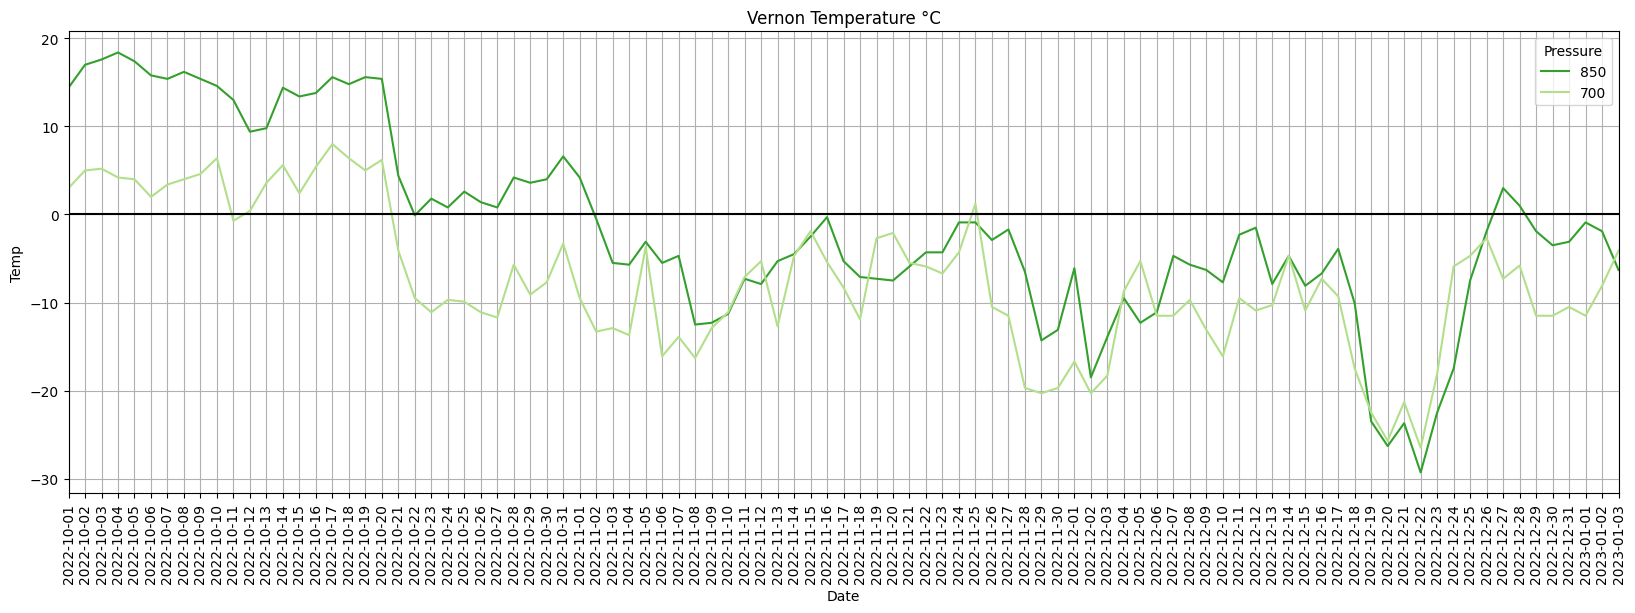

In [193]:
# Set figure details
plt.figure(figsize=(20,6))
plt.title("Vernon Temperature °C")
plt.xticks(rotation = 'vertical')
palette = sns.color_palette("Paired", n_colors=6)
order = [1, 0, 3, 2, 5, 4]
palette = [palette[idx] for idx in order]
hue_order = [850, 700]

# Line chart showing daily temps of Quillayute weather balloon at both 700 and 850 hPa
g = sns.lineplot(x='Date', y='Temp', hue='Pressure', data=df[df['Station'] == "Vernon"], palette=palette[2:4], hue_order=hue_order)
g.axhline(0, color='black')

# Display and Save graph
plt.xlim([0, len(df)/6 -1])
plt.grid()
plt.savefig("./figures/temp/VernonTemps-{:0>4d}-{:0>2d}-{:0>2d}.png".format(datetime.now().year, datetime.now().month, datetime.now().day),
                    format='png',dpi=150)
plt.show()

## Plot for Port Hardy
Plot for Temperature values at Port Hardy

---

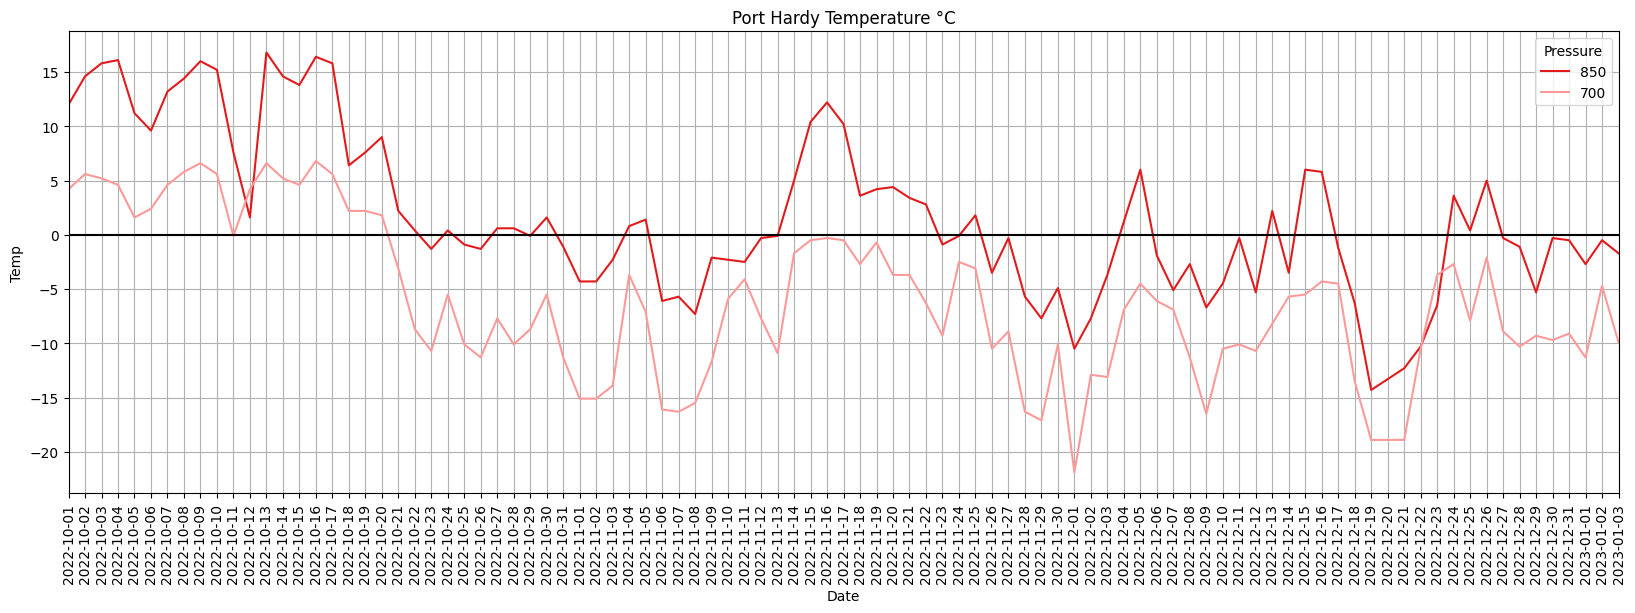

In [194]:
# Set figure details
plt.figure(figsize=(20,6))
plt.title("Port Hardy Temperature °C")
plt.xticks(rotation = 'vertical')
palette = sns.color_palette("Paired", n_colors=6)
order = [1, 0, 3, 2, 5, 4]
palette = [palette[idx] for idx in order]
hue_order = [850, 700]

# Line chart showing daily temps of Quillayute weather balloon at both 700 and 850 hPa
g = sns.lineplot(x='Date', y='Temp', hue='Pressure', data=df[df['Station'] == "Port Hardy"], palette=palette[4:6], hue_order=hue_order)
g.axhline(0, color='black')

# Display and Save graph
plt.xlim([0, len(df)/6 -1])
plt.grid()
plt.savefig("./figures/temp/PortHardyTemps-{:0>4d}-{:0>2d}-{:0>2d}.png".format(datetime.now().year, datetime.now().month, datetime.now().day),
                    format='png',dpi=150)
plt.show()

## Plot for All Stations
Tempterature readings for all stations plot on a single graph

---

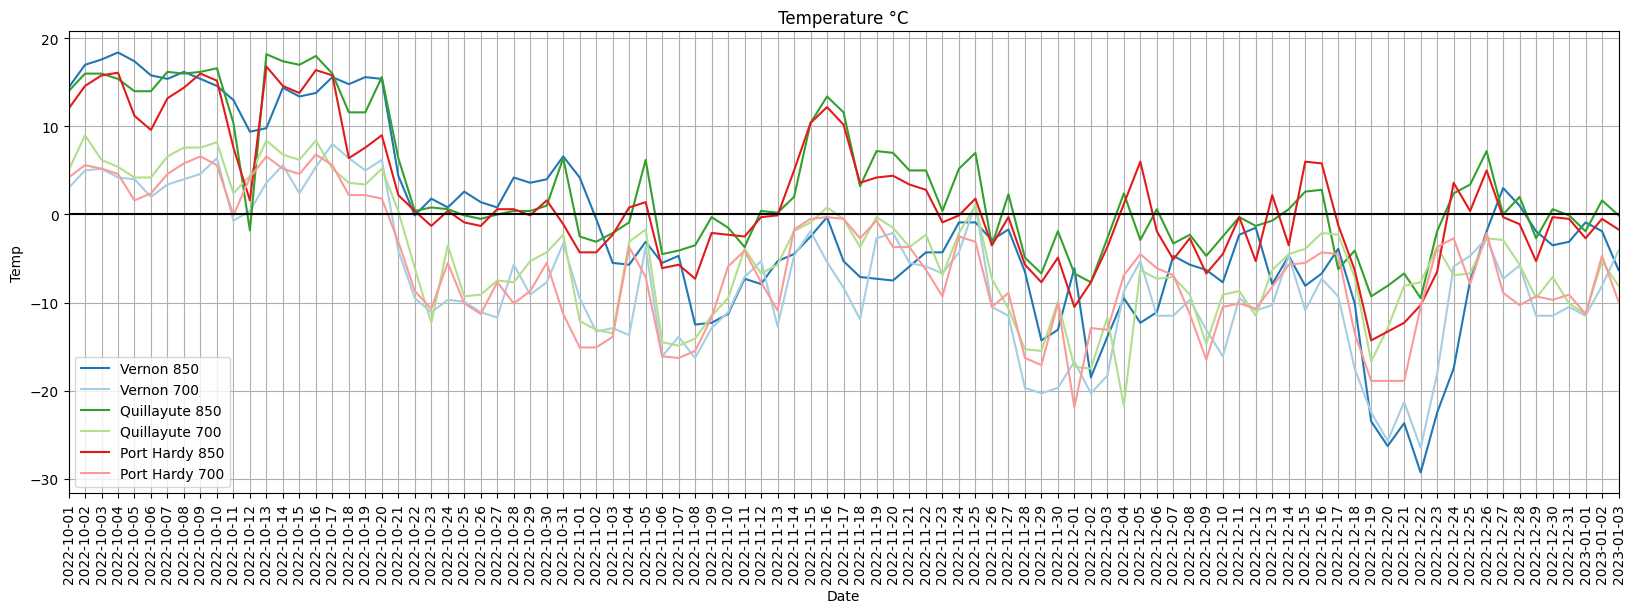

In [195]:
# Set figure details
plt.figure(figsize=(20,6))
plt.title("Temperature °C")
plt.xticks(rotation = 'vertical')

# Define desired order
order = [1, 0, 3, 2, 5, 4]
hue_order = [850, 700]

# Re-order color palette
palette = sns.color_palette("Paired", n_colors=6)
palette = [palette[idx] for idx in order]

# Re-order labels by desc pressure
labels=['Vernon 700', 'Vernon 850', 'Quillayute 700', 'Quillayute 850', 'Port Hardy 700', 'Port Hardy 850']
labels = [labels[idx] for idx in order]

# Line chart showing daily temps of Quillayute weather balloon at both 700 and 850 hPa
g = sns.lineplot(x='Date', y='Temp', hue='Pressure', data=df[df['Station'] == "Vernon"], palette=palette[:2], hue_order=hue_order)
g = sns.lineplot(x='Date', y='Temp', hue='Pressure', data=df[df['Station'] == "Quillayute"], palette=palette[2:4], hue_order=hue_order)
g = sns.lineplot(x='Date', y='Temp', hue='Pressure', data=df[df['Station'] == "Port Hardy"], palette=palette[4:6], hue_order=hue_order)
g.axhline(0, color='black')


# Rename legend with detailed labels
l = plt.legend()
for x, label in enumerate(labels):
    l.get_texts()[x].set_text(label)

# Display and Save graph
plt.xlim([0, len(df)/6 -1])
plt.grid()
plt.savefig("./figures/temp/PortHardyTemps-{:0>4d}-{:0>2d}-{:0>2d}.png".format(datetime.now().year, datetime.now().month, datetime.now().day),
                    format='png',dpi=150)
plt.show()

# Wind Plot
Using a wind rose, the direction and magnitude of wind from each region

In [196]:
# Function to truncate a colormap
# Can be used to remove white / black bookended values
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## Plot for Quillayute
Plot for Wind Speed & Direction values at Vernon

---

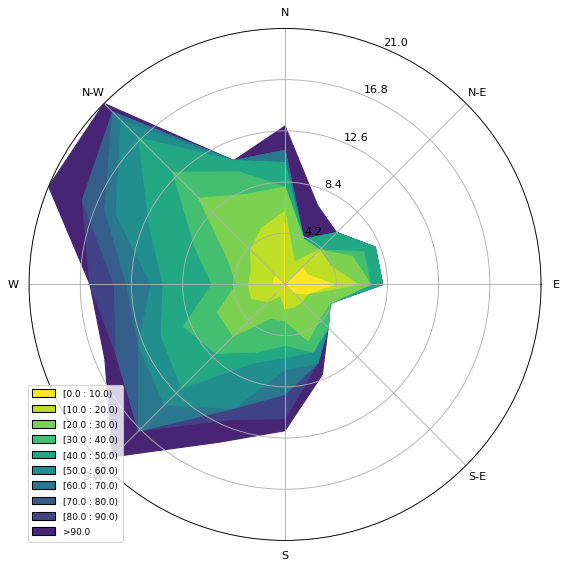

In [197]:
# Define color map and truncate to apropriate range
cmap = cm.viridis_r
cmap = truncate_colormap(cmap, minval=0, maxval=0.9)

# Populate speed and direction vars from DataFrame
wd = df[df['Station'] == "Quillayute"]['Wind_Direction'].to_list()
ws = df[df['Station'] == "Quillayute"]['Wind_Speed'].to_list()

# Plot wind rose for data set
ax = WindroseAxes.from_ax()
ax.contourf(wd, ws, bins=np.arange(0, 100, 10), cmap=cmap)
ax.set_legend()

# Save figure
plt.title("Quillayute Wind")
plt.savefig("./figures/wind/QuillayuteWind-{:0>4d}-{:0>2d}-{:0>2d}.png".format(datetime.now().year, datetime.now().month, datetime.now().day),
                    format='png',dpi=150)
plt.show()

## Plot for Vernon
Plot for Wind Speed & Direction values at Vernon

---

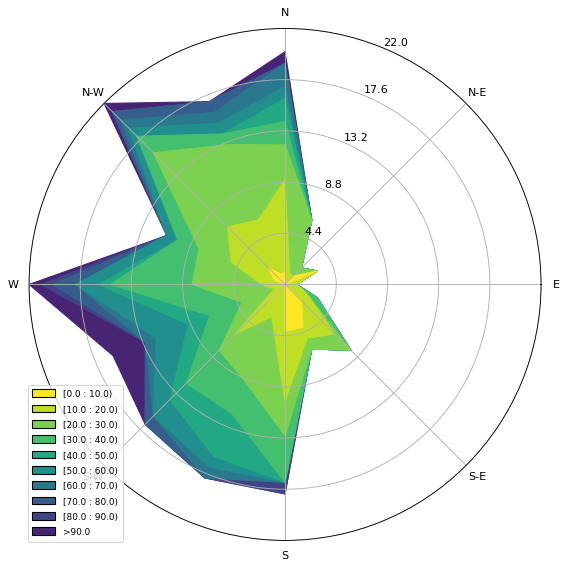

In [198]:
# Define color map and truncate to apropriate range
cmap = cm.viridis_r
cmap = truncate_colormap(cmap, minval=0, maxval=0.9)

# Populate speed and direction vars from DataFrame
wd = df[df['Station'] == "Vernon"]['Wind_Direction'].to_list()
ws = df[df['Station'] == "Vernon"]['Wind_Speed'].to_list()

# Plot wind rose for data set
ax = WindroseAxes.from_ax()
ax.contourf(wd, ws, bins=np.arange(0, 100, 10), cmap=cmap)
ax.set_legend()

# Save figure
plt.title("Vernon Wind")
plt.savefig("./figures/wind/VernonWind-{:0>4d}-{:0>2d}-{:0>2d}.png".format(datetime.now().year, datetime.now().month, datetime.now().day),
                    format='png',dpi=150)
plt.show()

## Plot for Port Hardy
Plot for Wind Speed & Direction values at Port Hardy

---

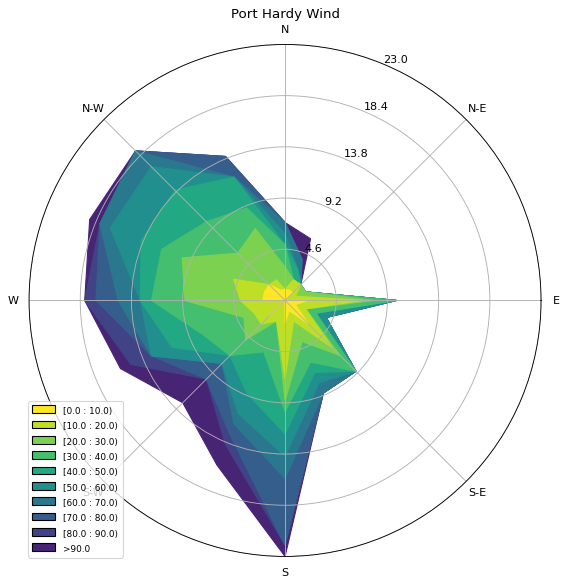

In [200]:
# Define color map and truncate to apropriate range
cmap = cm.viridis_r
cmap = truncate_colormap(cmap, minval=0, maxval=0.9)

# Populate speed and direction vars from DataFrame
wd = df[df['Station'] == "Port Hardy"]['Wind_Direction'].to_list()
ws = df[df['Station'] == "Port Hardy"]['Wind_Speed'].to_list()

# Plot wind rose for data set
ax = WindroseAxes.from_ax()
ax.contourf(wd, ws, bins=np.arange(0, 100, 10), cmap=cmap)
ax.set_legend()

# Save figure
plt.title("Port Hardy Wind")
plt.savefig("./figures/wind/PortHardyWind-{:0>4d}-{:0>2d}-{:0>2d}.png".format(datetime.now().year, datetime.now().month, datetime.now().day),
                    format='png',dpi=150)
plt.show()

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
#  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ NOTES ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

## APP (2)

Easy to read / on the go / big text

700 | 3020m | -7 |
- - - - - - - - -
850 | 1590m | -9 |

Wind direction in an arrow // color coded magnitude and direction


Gathering data from brohm ridge needs to be done hourly
- looking like avalanche canada page on Wx


## Drive (1)
Guide daily forms
- Integrate to slack

Users need to see
- Just the weather info


## Webcms (3)
(load one by one -- javascript)
- cayoosh
- whistler peak
- blackcomb
- rubble creek
- brohm ridge
- s2s


western developement fund of canada /// Western Economic Diversification Canada

In [ ]:
table = [dates]
dates = [locations]
location = [variables]